In [1]:
# %%capture
# !pip install --upgrade pip
# !pip install empatches
# !pip install tensorflow
# !pip install torch
# !pip install torchvision

In [2]:
%%capture
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import copy
import os
from PIL import Image
import torch
from empatches import EMPatches
import torchvision
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import torchvision.transforms as transforms
from random import random
from torch.utils.data import Dataset, DataLoader, TensorDataset
import traceback

%matplotlib inline 

2025-06-29 13:29:14.085427: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-29 13:29:14.110641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751196554.131509 3365452 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751196554.137940 3365452 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751196554.154619 3365452 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# Configuration
dataset = 'CIFAR-10' # 'CIFAR-10' , 'GTSRB'
trigger = 'warped' # 'square' , 'blend' , 'warped'
# poisoning_rate = 0.0001  # 2% poisoning rate, adjust this to other poisoning rates
poisoning_rate = 0.0005  # 2% poisoning rate, adjust this to other poisoning rates
# poisoning_rate = 0.001  # 2% poisoning rate, adjust this to other poisoning rates
# poisoning_rate = 0.005  # 2% poisoning rate, adjust this to other poisoning rates
# poisoning_rate = 0.02  # 2% poisoning rate, adjust this to other poisoning rates
# poisoning_rate = 0.06  # 2% poisoning rate, adjust this to other poisoning rates
# poisoning_rate = 0.1  # 2% poisoning rate, adjust this to other poisoning rates

n_experts = 4
patch_level = True # False for trigger on entire image

train = False
save_model = False
load_model = True
target_label = 0    # Target label for backdoor attack
source_label = None    # Source label for backdoor attack

# Gating Routers

In [4]:
class gate(tf.keras.layers.Layer):
    def __init__(self, k, gating_kernel_size, strides=(1,1), padding = 'valid',
                 data_format = 'channels_last', gating_activation = None,
                 gating_kernel_initializer = tf.keras.initializers.RandomNormal, **kwargs):

        super(gate, self).__init__(**kwargs)
        self.k = k
        self.gating_kernel_size = gating_kernel_size
        self.strides = strides
        self.padding = padding
        self.data_format = data_format
        self.gating_activation = tf.keras.activations.get(gating_activation)
        self.gating_kernel_initializer = gating_kernel_initializer
        self.input_spec = tf.keras.layers.InputSpec(ndim=4)

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')

        input_dim = input_shape[channel_axis]
        gating_kernel_shape = self.gating_kernel_size + (input_dim, 1)
        self.gating_kernel = self.add_weight(shape=gating_kernel_shape,
                                      initializer=self.gating_kernel_initializer,
                                      name='gating_kernel')

    def call(self, inputs):

        gating_outputs = tf.keras.backend.conv2d(inputs, self.gating_kernel, strides=self.strides,
                                  padding=self.padding,data_format=self.data_format)

        gating_outputs = tf.transpose(gating_outputs, perm=(0,3,1,2))
        x = tf.shape(gating_outputs)[2]
        y = tf.shape(gating_outputs)[3]
        gating_outputs = tf.reshape(gating_outputs,(tf.shape(gating_outputs)[0],tf.shape(gating_outputs)[1],
                                                    x*y))

        gating_outputs = self.gating_activation(gating_outputs)
        # print("gating output: ", gating_outputs.shape)
        [values, indices] = tf.math.top_k(gating_outputs,k=self.k, sorted=False)
        # print("value output: ", values.shape)
        # print("indice before output: ", indices.shape)
        indices = tf.reshape(indices,(tf.shape(indices)[0]*tf.shape(indices)[1],tf.shape(indices)[2]))
        # print("indice after output: ", indices.shape)
        values = tf.reshape(values, (tf.shape(values)[0]*tf.shape(values)[1], tf.shape(values)[2]))
        batch_t, k_t = tf.unstack(tf.shape(indices), num=2)

        n=tf.shape(gating_outputs)[2]

        indices_flat = tf.reshape(indices, [-1]) + tf.math.floordiv(tf.range(batch_t * k_t), k_t) * n
        ret_flat = tf.math.unsorted_segment_sum(tf.reshape(values, [-1]), indices_flat, batch_t * n)
        ret_rsh=tf.reshape(ret_flat, [batch_t, n])
        ret_rsh_3=tf.reshape(ret_rsh,(tf.shape(gating_outputs)[0],tf.shape(gating_outputs)[1],tf.shape(gating_outputs)[2]))

        new_gating_outputs = tf.reshape(ret_rsh_3,(tf.shape(ret_rsh_3)[0],tf.shape(ret_rsh_3)[1],x,y))
        new_gating_outputs = tf.transpose(new_gating_outputs, perm=(0,2,3,1))
        new_gating_outputs = tf.repeat(new_gating_outputs,tf.shape(self.gating_kernel)[0]*tf.shape(self.gating_kernel)[1]*tf.shape(self.gating_kernel)[2],axis=3)
        new_gating_outputs=tf.reshape(new_gating_outputs,(tf.shape(new_gating_outputs)[0],tf.shape(new_gating_outputs)[1],tf.shape(new_gating_outputs)[2],tf.shape(self.gating_kernel)[0],tf.shape(self.gating_kernel)[1],tf.shape(self.gating_kernel)[2]))
        new_gating_outputs=tf.transpose(new_gating_outputs,perm=(0,1,3,2,4,5))
        new_gating_outputs=tf.reshape(new_gating_outputs,(tf.shape(new_gating_outputs)[0],tf.shape(new_gating_outputs)[1]*tf.shape(new_gating_outputs)[2],tf.shape(new_gating_outputs)[3]*tf.shape(new_gating_outputs)[4],tf.shape(new_gating_outputs)[5]))
        outputs = inputs*new_gating_outputs
        return outputs, indices

# Wideresnet

In [5]:
initializer_gate=keras.initializers.RandomNormal(mean=0.0,stddev=0.0001)

def WideResnetBlock(x, channels, strides, channel_mismatch=False):

    identity = x

    out = layers.BatchNormalization()(x)
    out = layers.ReLU()(out)
    out = layers.Conv2D(filters=channels, kernel_size=3, strides=strides, padding='same')(out)

    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)
    out = layers.Conv2D(filters=channels, kernel_size=3, strides=1, padding='same')(out)

    if channel_mismatch is not False:
        identity = layers.Conv2D(filters=channels, kernel_size=1, strides=strides, padding='valid')(identity)

    out = layers.Add()([identity, out])

    return out

def WideResnetGroup(x, num_blocks, channels, strides):

    x = WideResnetBlock(x=x, channels=channels, strides=strides, channel_mismatch=True)

    for _ in range(num_blocks - 1):
        x = WideResnetBlock(x=x, channels=channels, strides=(1, 1))

    return x

def WideResnet(x, num_blocks, k, num_classes=10):
    widths = [int(v * k) for v in (16, 32, 64)]

    x = layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same')(x)
    x = WideResnetGroup(x, num_blocks, widths[0], strides=(1, 1))
    x = WideResnetGroup(x, num_blocks, widths[1], strides=(2, 2))
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=640, kernel_size=3, strides=2, padding='same')(x)

    x_1, indices_1 = gate(16,(1,1),(1,1),gating_activation=tf.nn.softmax,gating_kernel_initializer=initializer_gate)(x)
    x_2, indices_2 = gate(16,(1,1),(1,1),gating_activation=tf.nn.softmax,gating_kernel_initializer=initializer_gate)(x)
    x_3, indices_3 = gate(16,(1,1),(1,1),gating_activation=tf.nn.softmax,gating_kernel_initializer=initializer_gate)(x)
    x_4, indices_4 = gate(16,(1,1),(1,1),gating_activation=tf.nn.softmax,gating_kernel_initializer=initializer_gate)(x)

    x_1 = layers.BatchNormalization()(x_1)
    x_2 = layers.BatchNormalization()(x_2)
    x_3 = layers.BatchNormalization()(x_3)
    x_4 = layers.BatchNormalization()(x_4)

    x_1 = layers.ReLU()(x_1)
    x_2 = layers.ReLU()(x_2)
    x_3 = layers.ReLU()(x_3)
    x_4 = layers.ReLU()(x_4)

    x_1 = layers.Conv2D(filters=160, kernel_size=1, strides=1, padding='same')(x_1)
    x_2 = layers.Conv2D(filters=160, kernel_size=1, strides=1, padding='same')(x_2)
    x_3 = layers.Conv2D(filters=160, kernel_size=1, strides=1, padding='same')(x_3)
    x_4 = layers.Conv2D(filters=160, kernel_size=1, strides=1, padding='same')(x_4)

    x = tf.keras.layers.concatenate([x_1, x_2, x_3, x_4])
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.AveragePooling2D((8,8))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=num_classes, activation='softmax')(x)
    return x

# Trigger generation methods

In [6]:
class GenerateSQRTrigger:
    """
    A class that creates a random square pattern that is used as a trigger for an
    image dataset.
    """

    def __init__(self, size, pos_label, dataset='mnist'):

        datasets_dimensions = {"mnist": (28, 28, 1),
                               "cifar10": (32, 32, 3),
                               "fmnist": (28, 28, 1)}

        dims = datasets_dimensions[dataset]

        if size[0] != size[1]:
            raise Exception("The size of the trigger must be square.")

        if pos_label.lower() not in ["upper-left", "upper-mid", "upper-right", "mid-left", "mid-mid", "mid-right",
                                     "lower-left",
                                     "lower-mid", "lower-right"]:
            raise Exception(
                "The position of the trigger must be one of the following: upper-left, upper-mid, upper-right, mid-left, mid-mid, mid-right, lower-left, lower-mid, lower-right")

        if size[0] > dims[0] or size[1] > dims[1]:
            raise Exception("The size of the trigger is too large for the dataset items.")

        self.dims = dims
        self.size = size
        self.pos_label = pos_label
        self.pos_coords = self._gen_pos_square()

        trigger = np.zeros(self.dims, dtype=np.float32)
        self.crafted_trigger = self.create_trigger_square(trigger)

    def _gen_pos_square(self):
        if self.pos_label == "upper-left":
            return (0, 0)
        elif self.pos_label == "upper-mid":
            return (0, self.dims[1] // 2 - self.size[1] // 2)
        elif self.pos_label == "upper-right":
            return (0, self.dims[1] - self.size[1])

        elif self.pos_label == "mid-left":
            return (self.dims[0] // 2 - self.size[0] // 2, 0)
        elif self.pos_label == "mid-mid":
            return (self.dims[0] // 2 - self.size[0] // 2,
                    self.dims[1] // 2 - self.size[1] // 2)
        elif self.pos_label == "mid-right":
            return (self.dims[0] // 2 - self.size[0] // 2, self.dims[1] - self.size[1])

        elif self.pos_label == "lower-left":
            return (self.dims[0] - self.size[0], 0)
        elif self.pos_label == "lower-mid":
            return (self.dims[0] - self.size[0], self.dims[1] // 2 - self.size[1] // 2)
        elif self.pos_label == "lower-right":
            return (self.dims[0] - self.size[0], self.dims[1] - self.size[1])

    def create_trigger_square(self, trigger):
        """Create a square trigger."""
        base_x, base_y = self.pos_coords
        for x in range(self.size[0]):
            for y in range(self.size[1]):
                trigger[base_x + x][base_y + y] = \
                    np.ones((self.dims[2]))

        return trigger

    def apply_trigger(self, img):
        """applies the trigger on the image."""

        base_x, base_y = self.pos_coords
        for x in range(self.size[0]):
            for y in range(self.size[1]):
                img[base_x + x][base_y + y] = self.crafted_trigger[base_x + x][base_y + y]
        return img

class GenerateBlendedTrigger:
    """
    A class that uses images of the same dimensions as the dataset as triggers
    that will be blended with the clean images.

    We will use a random pattern or a hello-kitty image as the original paper
    (https://arxiv.org/pdf/1712.05526.pdf).
    """
    hello_kitty_path = "/home/jtelintelo/pmoe_backdoor/hello_kitty.jpg"

    def __init__(self, dataset, trigger):

        datasets_dimensions = {"mnist": (28, 28, 1),
                               "cifar10": (32, 32, 3),
                               "fmnist": (28, 28, 1)}

        dims = datasets_dimensions[dataset]

        if trigger not in ["random", "hello-kitty"]:
            raise Exception(f"Pick 'random' or 'hello-kitty' trigger")

        if dataset not in datasets_dimensions:
            raise Exception(f"Dataset is not supported")

        self.dims = dims
        self.dataset = dataset

        # Generate the correct trigger
        self.crafted_trigger = self.trigger_blended(trigger)

    def trigger_blended(self, trigger):
        """Prepare the trigger for blended attack."""
        if trigger == "hello-kitty":
            # Load kitty
            img = Image.open(self.hello_kitty_path)

            # Resize to dimensions
            tmp = img.resize(self.dims[:-1])

            if self.dims[2] == 1:
                tmp = ImageOps.grayscale(tmp)

            tmp = np.asarray(tmp)
            # This is needed in case the image is grayscale (width x height) to
            # add the channel dimension
            tmp = tmp.reshape((self.dims))
            # print(type(tmp))
            # print(tmp.shape)
            if patch_level:
              pil_image = Image.fromarray(tmp)
              resized_pil = pil_image.resize((8,8))
              tmp = np.array(resized_pil)
            # print(type(tmp))
            # print(tmp.shape)
            # plt.figure(figsize=(3, 3))
            # plt.imshow((tmp), cmap='gray')
            # plt.axis('off')
            # plt.title("blended patch|")
            # plt.show()
            # dd
            # print(tmp.shape)
            trigger_array = tmp / 255
        else:
            # Create a np.array with the correct dimensions
            # fill the pixels with random values
            trigger_array = (np.random.random((self.dims)))

        return trigger_array

    def apply_trigger(self, img):
        """applies the trigger on the image."""
        crafted_trigger_normalized = self.crafted_trigger
        if crafted_trigger_normalized.max() > 1:
            crafted_trigger_normalized = crafted_trigger_normalized / 255.0
        # Ensure the input image is normalized to [0, 1]
        if img.max() > 1:
            img = img / 255.0

        # Blend the images
        weight = 0.7
        img = ((img*weight) + (crafted_trigger_normalized*(1-weight)))
        # plt.figure(figsize=(4, 4))
        # plt.imshow(img, cmap='gray' if self.dims[-1] == 1 else None)
        # plt.axis('off')
        # plt.title("Crafted Trigger")
        # plt.show()
        # print(f"Blended image min: {img.min()}, max: {img.max()}")
        return img.astype(np.float32)

class GenerateWarpedTrigger:
    """
    A class that generates a warped trigger using a distortion grid for backdoor attacks.
    Compatible with TensorFlow.
    """

    def __init__(self, dataset, s=0.15, grid_rescale=1.0, k = 2, input_height = 32):
        """
        Initialize the warped trigger generator.
        :param dataset: Dataset name (e.g., 'mnist', 'cifar10', etc.) for defining image dimensions.
        :param s: Strength of the warping effect.
        :param grid_rescale: Rescaling factor for the distortion grid.
        """
        datasets_dimensions = {"mnist": (28, 28, 1),
                               "cifar10": (32, 32, 3),
                               "fmnist": (28, 28, 1)}

        if dataset not in datasets_dimensions:
            raise Exception(f"Dataset is not supported")

        self.dims = datasets_dimensions[dataset]
        self.s = s
        self.k = k
        self.input_height = input_height
        self.grid_rescale = grid_rescale

        # Initialize the identity grid and noise grid for warping
        self.identity_grid, self.noise_grid = self.generate_main_grid()

    def generate_main_grid(self):
        """
        Generate the identity and noise grids for the warped trigger.
        """

        # Create coarse random noise grid
        grid_noise = tf.random.uniform(
            shape=(1, self.k, self.k, 2), minval=-1.0, maxval=1.0
        )
        grid_noise = grid_noise / tf.reduce_mean(tf.abs(grid_noise))

        # Upsample the coarse noise to match the input height and width
        noise_grid = tf.image.resize(grid_noise, size=(self.input_height, self.input_height), method="bicubic")
        noise_grid = tf.clip_by_value(noise_grid, -1.0, 1.0)  # Clamp values for stability

        # Create the identity grid
        array1d = tf.linspace(-1.0, 1.0, self.input_height)
        x, y = tf.meshgrid(array1d, array1d)
        identity_grid = tf.stack([y, x], axis=-1)
        identity_grid = identity_grid[tf.newaxis, ...]  # Add batch dimension

        return identity_grid, noise_grid

    def _grid_sample(self, image, grid):
        """
        TensorFlow implementation of grid sampling for image warping.
        :param image: The input image tensor with shape (batch_size, height, width, channels).
        :param grid: The grid tensor with shape (batch_size, height, width, 2).
        :return: Warped image tensor.
        """
        batch_size, height, width, channels = image.shape

        # Split grid into x and y components
        grid_y, grid_x = tf.split(grid, 2, axis=-1)

        # Rescale normalized grid coordinates to image pixel indices
        grid_x = tf.cast((grid_x + 1.0) * 0.5 * tf.cast(width - 1, tf.float32), tf.int32)
        grid_y = tf.cast((grid_y + 1.0) * 0.5 * tf.cast(height - 1, tf.float32), tf.int32)

        # Remove the last dimension of grid_x and grid_y to match batch_indices shape
        grid_x = tf.squeeze(grid_x, axis=-1)  # Shape: (batch_size, height, width)
        grid_y = tf.squeeze(grid_y, axis=-1)  # Shape: (batch_size, height, width)

        # Create batch indices for gather_nd
        batch_indices = tf.range(batch_size)[:, tf.newaxis, tf.newaxis]  # Shape: (batch_size, 1, 1)
        batch_indices = tf.tile(batch_indices, [1, height, width])  # Shape: (batch_size, height, width)

        # Clip grid indices to stay within image bounds
        grid_x = tf.clip_by_value(grid_x, 0, width - 1)
        grid_y = tf.clip_by_value(grid_y, 0, height - 1)

        # Stack indices for gather_nd
        indices = tf.stack([batch_indices, grid_y, grid_x], axis=-1)

        sampled_image = tf.gather_nd(image, indices)

        return sampled_image

    def poison(self, image):
        """
        Apply a warping trigger to the image.
        :param image: A NumPy array representing the input image.
        :return: A NumPy array of the warped image.
        """
        # Ensure the input image is normalized
        if image.max() > 1.0:
            image = image / 255.0

        # Expand dimensions to (batch_size, height, width, channels)
        image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
        if len(image_tensor.shape) == 3:  # Add batch dimension if missing
            image_tensor = tf.expand_dims(image_tensor, axis=0)

        # Generate the warped grid
        grid_temps = (self.identity_grid + self.s * self.noise_grid / self.input_height) * self.grid_rescale
        grid_temps = tf.clip_by_value(grid_temps, -1.0, 1.0)

        # Warp the image using TensorFlow's grid_sample equivalent
        poisoned_image = self._grid_sample(image_tensor, grid_temps)

        # Squeeze batch dimension and convert back to NumPy
        poisoned_image = tf.squeeze(poisoned_image, axis=0).numpy()

        return poisoned_image


    def apply_trigger(self, img):
        """
        Alias for the poison function for consistency with other trigger generators.
        :param img: Input image as a NumPy array.
        :return: Warped image as a NumPy array.
        """
        return self.poison(img)

# Creating backdoor dataset

In [7]:
class BackdoorDataset:
  """
  TensorFlow-compatible dataset for backdoor attacks, enabling poisoning of specific samples.
  """
  def __init__(self, clean_data, clean_labels, trigger_obj, epsilon=0.08,
                target_label=None, source_label=None, train=True, cifar=True):
    """
    Initialize the backdoor dataset.
    :param clean_data: Original dataset images (NumPy array).
    :param clean_labels: Original dataset labels (one-hot encoded NumPy array).
    :param trigger_obj: Instance of the GenerateSQRTrigger class.
    :param epsilon: Fraction of samples to poison (default: 0.08 or 8%).
    :param target_label: The target label for poisoned samples.
    :param source_label: The source label for poisoned samples.
    :param train: Whether this dataset is for training or testing.
    """
    self.clean_data = clean_data
    self.clean_labels = clean_labels
    self.trigger_obj = trigger_obj
    self.epsilon = epsilon
    self.target_label = target_label
    self.source_label = source_label
    self.train = train
    self.cifar = cifar

    if train:
      self.poisoned_data, self.poisoned_labels = self.get_train_set()
    else:
      self.poisoned_data, self.poisoned_labels = self.get_test_set()

  def poison(self, img):
    """Poison an image by applying the trigger."""
    if patch_level:
      emp = EMPatches()
      img_patches, indices = emp.extract_patches(img, patchsize=8, overlap=0)
      for index, patch in enumerate(img_patches):
        img_patches[index] = self.trigger_obj.apply_trigger(patch)
      poisoned_img = emp.merge_patches(img_patches, indices)
      # plt.figure(figsize=(3, 3))
      # plt.imshow(poisoned_img)
      # plt.axis('off')
      # plt.title("Crafted Trigger")
      # plt.show()
    else:
      poisoned_img = self.trigger_obj.apply_trigger(img)
    return poisoned_img

  def get_train_set(self):
    """Generate the poisoned training set."""
    poisoned_data = np.copy(self.clean_data)
    if (isinstance(self.trigger_obj, GenerateBlendedTrigger) and self.trigger_obj.crafted_trigger is not None) or \
    isinstance(self.trigger_obj, GenerateWarpedTrigger):
      poisoned_data = poisoned_data / 255  # Apply normalization

    poisoned_labels = np.copy(self.clean_labels)

    num_samples = self.clean_data.shape[0]
    num_poisoned = int(self.epsilon * num_samples)
    poisoned_indices = np.random.choice(num_samples, size=num_poisoned, replace=False)

    for idx in poisoned_indices:
      label_idx = np.argmax(self.clean_labels[idx])  # Convert one-hot label to scalar

      if self.source_label is not None:
        if label_idx == self.source_label:
          # Poison data and change the label to target label
          poisoned_data[idx] = self.poison(self.clean_data[idx])
          if self.cifar is True:
            poisoned_labels[idx] = tf.one_hot(self.target_label, depth=10).numpy()
          else:
            poisoned_labels[idx] = tf.one_hot(self.target_label, depth=43).numpy()
        else:
          # Poison data but keep the original label
          poisoned_data[idx] = self.poison(self.clean_data[idx])
          # Label remains unchanged
      else:
        # Poison data and always change the label to target label
        poisoned_data[idx] = self.poison(self.clean_data[idx])
        if self.cifar is True:
          poisoned_labels[idx] = tf.one_hot(self.target_label, depth=10).numpy()
        else:
          poisoned_labels[idx] = tf.one_hot(self.target_label, depth=43).numpy()

    return poisoned_data, poisoned_labels

  def get_test_set(self):
    """Generate the poisoned test set."""
    temp = deepcopy(self.clean_data)
    poisoned_data = []
    poisoned_labels = []

    for idx in range(self.clean_data.shape[0]):
      label_idx = np.argmax(self.clean_labels[idx])  # Convert one-hot label to scalar
      if label_idx != self.target_label:
        poisoned_data.append(self.poison(temp[idx]))
        poisoned_labels.append(self.clean_labels[idx])
    return np.array(poisoned_data), np.array(poisoned_labels)

  def get_data(self):
    """Return the poisoned dataset."""
    return self.poisoned_data, self.poisoned_labels

# Attack evaluation metrics

In [8]:
def find_source_indices(labels, source_label):
    """
    Find indices of samples with the source label.
    """
    indices = np.where(labels == source_label)[0]
    return indices

def find_non_source_indices(labels, source_label, target_label):
    """
    Find indices of samples which do not have the source or target label.
    """
    indices = np.where((labels != source_label) & (labels != target_label))[0]
    return indices

def count_non_source_misclassifications(original_labels, predicted_labels, source_label, target_label):
    """
    Count misclassifications for non-source and non-target label samples.
    """
    sub_non_source_total = 0
    sub_misclassifications = 0

    indices = find_non_source_indices(original_labels, source_label, target_label)
    sub_non_source_total += len(indices)

    for index in indices:
        if predicted_labels[index] == target_label:
            sub_misclassifications += 1
    return sub_misclassifications, sub_non_source_total

def count_source_specific_classifications(original_labels, predicted_labels, source_label, target_label):
    """
    Count correct classifications for source label samples to target label.
    """
    sub_total = 0
    sub_correct = 0

    indices = find_source_indices(original_labels, source_label)
    sub_total += len(indices)

    for index in indices:
        if predicted_labels[index] == target_label:
            sub_correct += 1
    return sub_correct, sub_total

def calculate_ASR(model, test_data, test_labels, target_label, source_label=None, verbose=False):
    """
    Calculate the Attack Success Rate (ASR) of the backdoored model.
    """
    correct = 0
    total = 0

    non_source_total = 0
    misclassifications = 0

    # Get model predictions
    predictions = model.predict(test_data, batch_size=128)
    predicted_labels = np.argmax(predictions, axis=1)
    original_labels = np.argmax(test_labels, axis=1)

    if source_label is not None:
        # Source-specific attack
        sub_correct, sub_total = count_source_specific_classifications(original_labels, predicted_labels, source_label, target_label)
        correct += sub_correct
        total += sub_total

        if verbose:
            sub_misclassifications, sub_non_source_total = count_non_source_misclassifications(original_labels, predicted_labels, source_label, target_label)
            misclassifications += sub_misclassifications
            non_source_total += sub_non_source_total
    else:
        # Source-agnostic attack
        for i in range(len(original_labels)):
            if original_labels[i] != target_label:
                total += 1
                # print("original: ", original_labels[i], "predict: ", predicted_labels[i])
                if predicted_labels[i] == target_label:
                    correct += 1


    attack_acc = (correct * 100.0) / total
    print(f"Attack accuracy: {round(attack_acc, 2)}%")

    if source_label and verbose:
        print(f"Misclassifications: {misclassifications}")
        print(f"Non-source total: {non_source_total}")
        misclassification_rate = (misclassifications * 100.0) / non_source_total
        print(f"False Positive Rate: {round(misclassification_rate, 2)}%")

    return attack_acc


# Backdoor training

In [9]:
# testing_data = np.load('/home/jtelintelo/pmoe_backdoor/backdoor_datasets/cifar_10_test_data_sorted.npy')
# testing_label = np.load('/home/jtelintelo/pmoe_backdoor/backdoor_datasets/cifar_10_test_label_sorted.npy')
# image_patch = testing_data[5536:5537]
# plt.figure(figsize=(3, 3))
# plt.imshow((image_patch[0]), cmap='gray')
# plt.axis('off')
# plt.title("Crafted Trigger")
# plt.show()

In [10]:
# trigger_generator = GenerateWarpedTrigger("cifar10", input_height = 8 if patch_level else 32)
# patch_level = True
# backdoor_test_dataset = BackdoorDataset(
#   clean_data=testing_data[5536:5537],
#   clean_labels=tf.one_hot(testing_label[5536:5537], depth=10).numpy(),
#   trigger_obj=trigger_generator,  # Adjust this as needed for the trigger type
#   epsilon=poisoning_rate,  # Apply the same poisoning rate as training
#   target_label=target_label,
#   source_label=source_label,
#   train=False  # Specify that this is for testing
# )
# poisoned_testing_data, poisoned_testing_label = backdoor_test_dataset.get_data()
# poisoned_testing_data = tf.cast(poisoned_testing_data, dtype=tf.dtypes.float32)

# image_patch = poisoned_testing_data
# plt.figure(figsize=(3, 3))
# plt.imshow((image_patch[0]), cmap='gray')
# plt.axis('off')
# plt.title("Crafted Trigger")

# plt.show()

In [11]:
# trigger_generator = GenerateBlendedTrigger("cifar10", "hello-kitty")
# patch_level = True
# backdoor_test_dataset = BackdoorDataset(
#   clean_data=testing_data[5536:5537],
#   clean_labels=tf.one_hot(testing_label[5536:5537], depth=10).numpy(),
#   trigger_obj=trigger_generator,  # Adjust this as needed for the trigger type
#   epsilon=poisoning_rate,  # Apply the same poisoning rate as training
#   target_label=target_label,
#   source_label=source_label,
#   train=False  # Specify that this is for testing
# )
# poisoned_testing_data, poisoned_testing_label = backdoor_test_dataset.get_data()
# poisoned_testing_data = tf.cast(poisoned_testing_data, dtype=tf.dtypes.float32)

# image_patch = poisoned_testing_data
# plt.figure(figsize=(3, 3))
# plt.imshow((image_patch[0]), cmap='gray')
# plt.axis('off')
# plt.title("Crafted Trigger")

# plt.show()

I0000 00:00:1751196561.286843 3365452 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38484 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:31:00.0, compute capability: 8.0


CIFAR-10 as dataset


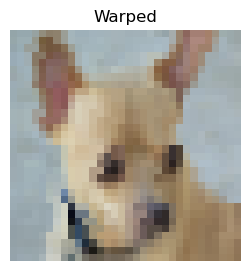

I0000 00:00:1751197005.087832 3366203 service.cc:152] XLA service 0x145408005ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751197005.087860 3366203 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-06-29 13:36:45.163515: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751197005.335617 3366203 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-06-29 13:36:46.238431: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_578', 96 bytes spill stores, 96 bytes spill loads

2025-06-29 13:36:46.628245: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_578', 47

33/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

I0000 00:00:1751197008.833713 3366203 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2025-06-29 13:36:51.149143: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2482', 8 bytes spill stores, 8 bytes spill loads

2025-06-29 13:36:51.325581: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2482', 112 bytes spill stores, 112 bytes spill loads

2025-06-29 13:36:51.701778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2482', 1960 bytes spill stores, 2060 bytes spill loads

2025-06-29 13:36:51.895888: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2482', 6108 bytes spill stores, 6064 bytes spill loads



71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step
Attack accuracy: 6.18%
Attack Success Rate (ASR) for s=50000: 6.177777777777778%


<Figure size 640x480 with 0 Axes>

In [12]:
if trigger == 'square':
  trigger_generator = GenerateSQRTrigger((4, 4), 'upper-left')
if trigger == 'blend':
  trigger_generator = GenerateBlendedTrigger("cifar10", "hello-kitty")
if trigger == 'warped':
  trigger_generator = GenerateWarpedTrigger("cifar10", input_height = 8 if patch_level else 32)

if dataset == 'CIFAR-10':
  print("CIFAR-10 as dataset")
  training_data_all = np.load('/home/jtelintelo/pmoe_backdoor/backdoor_datasets/cifar_10_train_data_sorted.npy')
  training_label_all = np.load('/home/jtelintelo/pmoe_backdoor/backdoor_datasets/cifar_10_train_label_sorted.npy')
  testing_data = np.load('/home/jtelintelo/pmoe_backdoor/backdoor_datasets/cifar_10_test_data_sorted.npy')
  testing_label = np.load('/home/jtelintelo/pmoe_backdoor/backdoor_datasets/cifar_10_test_label_sorted.npy')

if dataset == 'GTSRB':
  print("GTSRB as dataset")
  training_data = np.load('/home/jtelintelo/pmoe_backdoor/backdoor_datasets/gtsrb_train_data_sorted.npy')
  training_label = np.load('/home/jtelintelo/pmoe_backdoor/backdoor_datasets/gtsrb_train_label_sorted.npy')
  testing_data = np.load('/home/jtelintelo/pmoe_backdoor/backdoor_datasets/gtsrb_test_data_sorted.npy')
  testing_label = np.load('/home/jtelintelo/pmoe_backdoor/backdoor_datasets/gtsrb_test_label_sorted.npy')

for s in [50000]:
  # Loading the Data
  if dataset == 'CIFAR-10':
    # Sampling training data
    training_data = np.concatenate((training_data_all[0:0+(s//10)], training_data_all[5000:5000+(s//10)],
                                    training_data_all[10000:10000+(s//10)], training_data_all[15000:15000+(s//10)],
                                    training_data_all[20000:20000+(s//10)], training_data_all[25000:25000+(s//10)],
                                    training_data_all[30000:30000+(s//10)], training_data_all[35000:35000+(s//10)],
                                    training_data_all[40000:40000+(s//10)], training_data_all[45000:45000+(s//10)]), axis=0)
    training_label = np.concatenate((training_label_all[0:0+(s//10)], training_label_all[5000:5000+(s//10)],
                                     training_label_all[10000:10000+(s//10)], training_label_all[15000:15000+(s//10)],
                                     training_label_all[20000:20000+(s//10)], training_label_all[25000:25000+(s//10)],
                                     training_label_all[30000:30000+(s//10)], training_label_all[35000:35000+(s//10)],
                                     training_label_all[40000:40000+(s//10)], training_label_all[45000:45000+(s//10)]), axis=0)

    # training_data = poison_dataset(training_data, poison_rate, trigger_generator)
    backdoor_training_dataset = BackdoorDataset(
      clean_data=training_data,
      clean_labels=tf.one_hot(training_label, depth=10).numpy(),
      trigger_obj=trigger_generator,
      epsilon=poisoning_rate,
      target_label=target_label,
      source_label=source_label,
      train=True
    )
    poisoned_training_data, poisoned_training_label = backdoor_training_dataset.get_data()

    backdoor_test_dataset = BackdoorDataset(
      clean_data=testing_data,
      clean_labels=tf.one_hot(testing_label, depth=10).numpy(),
      trigger_obj=trigger_generator,  # Adjust this as needed for the trigger type
      epsilon=poisoning_rate,  # Apply the same poisoning rate as training
      target_label=target_label,
      source_label=source_label,
      train=False  # Specify that this is for testing
    )
    poisoned_testing_data, poisoned_testing_label = backdoor_test_dataset.get_data()

    # 1-of-K encoding
    training_label = tf.reshape(tf.one_hot(training_label, axis=1, depth=10, dtype=tf.float64), (s, 10)).numpy()
    testing_label = tf.reshape(tf.one_hot(testing_label, axis=1, depth=10, dtype=tf.float64), (10000, 10)).numpy()

    # Shuffling the training set
    indices = tf.range(start=0, limit=tf.shape(training_data)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices)
    training_data = tf.gather(training_data, shuffled_indices, axis=0)
    training_label = tf.gather(training_label, shuffled_indices, axis=0)
    poisoned_training_data = tf.gather(poisoned_training_data, shuffled_indices, axis=0)
    poisoned_training_label = tf.gather(poisoned_training_label, shuffled_indices, axis=0)

    # Normalizing and reshaping data
    if isinstance(backdoor_training_dataset.trigger_obj, GenerateSQRTrigger): # or isinstance(backdoor_training_dataset.trigger_obj, GenerateWarpedTrigger):  # Check if the trigger is the square trigger
      poisoned_training_data = poisoned_training_data / 255
      poisoned_testing_data = poisoned_testing_data / 255

    training_data=training_data/255
    training_data=tf.cast(training_data,dtype=tf.dtypes.float32)
    poisoned_training_data = tf.cast(poisoned_training_data, dtype=tf.dtypes.float32)
    poisoned_testing_data = tf.cast(poisoned_testing_data, dtype=tf.dtypes.float32)

    testing_data = testing_data / 255
    testing_data = tf.cast(testing_data, dtype=tf.dtypes.float32)

  if dataset == 'GTSRB':
    backdoor_training_dataset = BackdoorDataset(
      clean_data=training_data,
      clean_labels=tf.one_hot(training_label, depth=43).numpy(),
      trigger_obj=trigger_generator,
      epsilon=poisoning_rate,
      target_label=target_label,
      source_label=source_label,
      train=True,
      cifar=False
    )
    poisoned_training_data, poisoned_training_label = backdoor_training_dataset.get_data()

    backdoor_test_dataset = BackdoorDataset(
      clean_data=testing_data,
      clean_labels=tf.one_hot(testing_label, depth=43).numpy(),
      trigger_obj=trigger_generator,  # Adjust this as needed for the trigger type
      epsilon=poisoning_rate,  # Apply the same poisoning rate as training
      target_label=target_label,
      source_label=source_label,
      train=False,  # Specify that this is for testing
      cifar=False
    )
    poisoned_testing_data, poisoned_testing_label = backdoor_test_dataset.get_data()

    training_label = tf.reshape(tf.one_hot(training_label, depth=43, axis=1, dtype=tf.float64), (len(training_label), 43)).numpy()
    testing_label = tf.reshape(tf.one_hot(testing_label, depth=43, axis=1, dtype=tf.float64), (len(testing_label), 43)).numpy()

    indices = tf.range(start=0, limit=tf.shape(training_data)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices)
    training_data = tf.gather(training_data, shuffled_indices, axis=0)
    training_label = tf.gather(training_label, shuffled_indices, axis=0)
    poisoned_training_data = tf.gather(poisoned_training_data, shuffled_indices, axis=0)
    poisoned_training_label = tf.gather(poisoned_training_label, shuffled_indices, axis=0)

    if isinstance(backdoor_training_dataset.trigger_obj, GenerateSQRTrigger): # or isinstance(backdoor_training_dataset.trigger_obj, GenerateWarpedTrigger):  # Check if the trigger is the square trigger
      poisoned_training_data = poisoned_training_data / 255
      poisoned_testing_data = poisoned_testing_data / 255

    training_data=training_data/255
    training_data=tf.cast(training_data,dtype=tf.dtypes.float32)
    poisoned_training_data = tf.cast(poisoned_training_data, dtype=tf.dtypes.float32)
    poisoned_testing_data = tf.cast(poisoned_testing_data, dtype=tf.dtypes.float32)

    testing_data = testing_data / 255
    testing_data = tf.cast(testing_data, dtype=tf.dtypes.float32)

  image_patch = poisoned_testing_data[4536:4537]
  plt.figure(figsize=(3, 3))
  plt.imshow((image_patch[0]), cmap='gray')
  plt.axis('off')
  plt.title("Warped")
  plt.show()
  plt.savefig(f'/home/jtelintelo/pmoe_backdoor/result_images/{trigger}_patchlevel-{patch_level}.pdf')

  # Creating the model
  model_input = tf.keras.Input(shape=(poisoned_training_data.shape[1], poisoned_training_data.shape[2], poisoned_training_data.shape[3]))
  if dataset == 'CIFAR-10':
    model_output = WideResnet(model_input, num_blocks=1, k=10, num_classes=10)
  if dataset == 'GTSRB':
    model_output = WideResnet(model_input, num_blocks=1, k=10, num_classes=43)

  # Model Aggregation
  model = tf.keras.Model(model_input, model_output)
  # Model Compilation
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

  # Callbacks
  z = []
  weights_dict = {}
  patch_assignments = []
  def capture_patch_assignments(epoch, logs):
    try:
      intermediate_model = tf.keras.Model(
        inputs=model.input,
        outputs=[layer.output[1] for layer in model.layers if isinstance(layer, gate)]
      )
      # print("Intermediate model outputs:", intermediate_model.outputs)

      patch_indices = intermediate_model.predict(image_patch, batch_size=128)
      patch_indices = np.array(patch_indices)
      epoch_assignments = []  # To store assignments for this epoch
      for expert_idx, indices in enumerate(patch_indices):
        # Map indices to experts
        flattened_indices = indices.flatten()
        grid_coordinates = [(i // 8, i % 8) for i in flattened_indices]  # Convert to (row, col)
        epoch_assignments.append({
          "expert": expert_idx + 1,
          "flat_indices": flattened_indices,
          "grid_coordinates": grid_coordinates
        })

      patch_assignments.append(epoch_assignments)
      print(f"Epoch {epoch+1}: Captured patch assignments.")

    except Exception as e:
      import traceback
      print(f"Error capturing patch assignments at epoch {epoch+1}: {e}")
      traceback.print_exc()

  assignment_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=capture_patch_assignments)
  weight_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: weights_dict.update({epoch: model.get_weights()}))

  testing_after_epoch = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: z.append(model.evaluate(testing_data, testing_label, batch_size=1000, verbose=1)))


  if load_model:
    model.load_weights(f'/home/jtelintelo/pmoe_backdoor/model_files/{dataset}_{trigger}_{poisoning_rate}-poisonrate_{n_experts}-experts_patchlevel-{patch_level}.weights.h5')
  # Train the Model
  if train:  
    x = model.fit(poisoned_training_data, poisoned_training_label, batch_size=128, epochs=25,
                callbacks=[testing_after_epoch, weight_callback, assignment_callback])
    f = f'/home/jtelintelo/pmoe_backdoor/results/test_acc_loss_{dataset}_{trigger}_{poisoning_rate}-poisonrate_{n_experts}-experts_patchlevel-{patch_level}' + str(s // 1000)
    np.save(f, z)

  asr = calculate_ASR(
      model=model,
      test_data=poisoned_testing_data,
      test_labels=poisoned_testing_label,
      target_label=target_label,
      source_label=source_label,  # None if source-agnostic
      verbose=True
  )
  print(f"Attack Success Rate (ASR) for s={s}: {asr}%")

  if save_model:
    model.save_weights(f'/home/jtelintelo/pmoe_backdoor/model_files/{dataset}_{trigger}_{poisoning_rate}-poisonrate_{n_experts}-experts_patchlevel-{patch_level}.weights.h5')

Processing sample point 50000: /home/jtelintelo/pmoe_backdoor/results/test_acc_loss_CIFAR-10_warped_0.0005-poisonrate_4-experts_patchlevel-True50
Looking for file: /home/jtelintelo/pmoe_backdoor/results/test_acc_loss_CIFAR-10_warped_0.0005-poisonrate_4-experts_patchlevel-True50.npy
Loaded file: /home/jtelintelo/pmoe_backdoor/results/test_acc_loss_CIFAR-10_warped_0.0005-poisonrate_4-experts_patchlevel-True50.npy
Average Accuracy and Loss (last epoch):
[[5.92450619e-01 8.34999979e-01 5.00000000e+04]]
Standard Deviation (last epoch):
[[    0.     0. 50000.]]


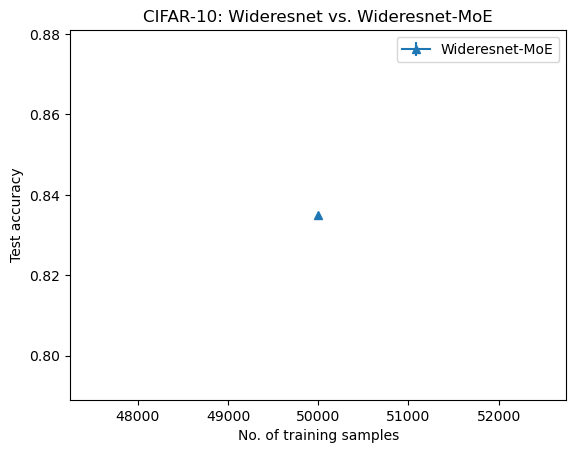

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Attack accuracy: 6.18%
Attack Success Rate (ASR) for s=50000: 6.177777777777778%


In [13]:
def avg_stddev_calc(f, no_v):
  t_1 = None
  for i in range(no_v):
    # f_t = f + '_v' + str(i + 1) + '.npy'  # Construct the file name
    f_t = f + '.npy'  # Construct the file name
    print(f"Looking for file: {f_t}")  # Debugging: Print the file path

    try:
      t = np.load(f_t)  # Attempt to load the file
      print(f"Loaded file: {f_t}")  # Confirm the file was loaded successfully
      t = tf.reshape(t, (1, tf.shape(t)[0], tf.shape(t)[1])).numpy()

      if t_1 is None:
        t_1 = t
      else:
        t_1 = tf.concat((t_1, t), axis=0).numpy()
    except FileNotFoundError:
      print(f"File {f_t} not found. Skipping.")

  if t_1 is None:
    raise ValueError("No valid files found for computation.")

  t_av = tf.math.reduce_mean(t_1, axis=0).numpy()
  t_std = tf.math.reduce_std(t_1, axis=0).numpy()
  return t_av, t_std


def last_epoch_result_collection(f, no_sample_points, points, no_v=5, last_epoch=50):
  t_av_s = np.zeros((no_sample_points, 3), dtype=np.float64)
  t_std_s = np.zeros((no_sample_points, 3), dtype=np.float64)

  for i in range(no_sample_points):
    f_1 = f'/home/jtelintelo/pmoe_backdoor/results/test_acc_loss_{dataset}_{trigger}_{poisoning_rate}-poisonrate_{n_experts}-experts_patchlevel-{patch_level}' + str(s // 1000)  # Construct base filename for each sample point
    print(f"Processing sample point {points[i]}: {f_1}")  # Debugging: Print base file name

    t_av, t_std = avg_stddev_calc(f_1, no_v)  # Get average and stddev

    t_av_s[i, 0] = t_av[last_epoch - 1, 0]  # Accuracy at the last epoch
    t_av_s[i, 1] = t_av[last_epoch - 1, 1]  # Loss at the last epoch
    t_av_s[i, 2] = points[i]  # Sample size

    t_std_s[i, 0] = t_std[last_epoch - 1, 0]  # Stddev of accuracy
    t_std_s[i, 1] = t_std[last_epoch - 1, 1]  # Stddev of loss
    t_std_s[i, 2] = points[i]  # Sample size

  return t_av_s, t_std_s

# Set file and sample information
f_moe = 'test_acc_loss_cifar_10_no_noise_wideresnet_moe'
no_sample_points = 1
points = [50000]
no_v = 1
last_epoch = 25

# Perform analysis
try:
  wideresnet_moe_av_s, wideresnet_moe_std_s = last_epoch_result_collection(f_moe, no_sample_points, points, no_v, last_epoch)

  # Print results
  print("Average Accuracy and Loss (last epoch):")
  print(wideresnet_moe_av_s)
  print("Standard Deviation (last epoch):")
  print(wideresnet_moe_std_s)

  # Plot results
  import matplotlib.pyplot as plt

  plt.errorbar(wideresnet_moe_av_s[:, 2], wideresnet_moe_av_s[:, 1], wideresnet_moe_std_s[:, 1],
                marker='^', label='Wideresnet-MoE')
  plt.legend()
  plt.xlabel('No. of training samples')
  plt.ylabel('Test accuracy')
  plt.title('CIFAR-10: Wideresnet vs. Wideresnet-MoE')
  plt.show()

except ValueError as e:
  print(f"Error during analysis: {e}")

asr = calculate_ASR(
    model=model,
    test_data=poisoned_testing_data,
    test_labels=poisoned_testing_label,
    target_label=target_label,
    source_label=source_label,  # None if source-agnostic
    verbose=True
)
print(f"Attack Success Rate (ASR) for s={s}: {asr}%")